In [115]:
module MclWorld

using Plots
using Distributions
using StatsBase
using LinearAlgebra
using Printf
using Logging
Logging.disable_logging(Logging.Info)

include("../scripts/robot.jl")
import .RealRobotWorld: RealRobot, RealCamera
import .RealRobotWorld: IdealAgent, Agent, Landmark, Map, Camera, Robot, World
import .RealRobotWorld: data, decision, state_transition, circle_shape, draw, append
import .RealRobotWorld: observation_function

mutable struct Particle
    pose::Array{Float64}
    weight::Float64

    function Particle(
        pose,
        weight)

        new(
            pose,
            weight
        )
    end

end

function motion_update(self::Particle, nu, omega, time, noise_rate_pdf)
    ns = rand(noise_rate_pdf)
    noised_nu = nu + ns[1] * sqrt(abs(nu)/time) + ns[2] * sqrt(abs(omega)/time)
    noised_omega = omega + ns[3] * sqrt(abs(nu)/time) + ns[4] * sqrt(abs(omega)/time)
    self.pose = state_transition(noised_nu, noised_omega, time, self.pose)    
end

function observation_update(self::Particle, observation, map, distance_dev_rate, direction_dev)
    for (key, value) in observation
        
        obs_pos = value
        obs_id = key

        pos_on_map = map.landmarks[obs_id].pos        
        particle_suggest_pos=observation_function(self.pose, pos_on_map)

        distance_dev = distance_dev_rate*particle_suggest_pos[1]
        cov = diagm([distance_dev^2, direction_dev^2])
        self.weight = self.weight * pdf(MvNormal(particle_suggest_pos, cov), obs_pos)
    end
end

mutable struct Mcl
    init_pose::Array{Float64}
    num::Int64
    map::Map
    particles::Array{Particle}
    distance_dev_rate::Float64
    direction_dev::Float64
    motion_noise_rate_pdf::MvNormal
    ml::Particle
    pose::Array{Float64}

    function Mcl(
        init_pose,
        num;
        map=Map(),
        particles=[Particle(init_pose, 1.0/num) for i in 1:num],
        distance_dev_rate=0.14,
        direction_dev=0.05,
        motion_noise_stds=Dict([("nn", 0.19), ("no", 0.001), ("on", 0.13), ("oo", 0.2)]),
        ml = particles[1],
        pose = ml.pose
        )
    
        c = diagm([motion_noise_stds["nn"]^2, motion_noise_stds["no"]^2, motion_noise_stds["on"]^2, motion_noise_stds["oo"]^2])
        motion_noise_rate_pdf = MvNormal([0, 0, 0, 0], c)
    
        new(
            init_pose,
            num,
            map,
            particles,
            distance_dev_rate,
            direction_dev,
            motion_noise_rate_pdf,
            ml,
            pose
        )
    end

end

function set_ml(self::Mcl)
    i = argmax([p.weight for p in self.particles])
    self.ml = self.particles[i]
    self.pose = self.ml.pose
end

function draw(self::Mcl, plt)    
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    scale=0.5
    quiver!(plt, xs, ys, quiver=(scale*vxs, scale*vys), c=:orange)
end

function motion_update(self::Mcl, nu, omega, time)
    for p in self.particles
       motion_update(p, nu, omega, time, self.motion_noise_rate_pdf) 
    end
end

function observation_update(self::Mcl, observation)
    for p in self.particles
        observation_update(p, observation, self.map, self.distance_dev_rate, self.direction_dev)
    end
    set_ml(self)
    resampling_system(self)
end

function resampling_random_choise(self::Mcl)
    ws = [e.weight for e in self.particles]
    if sum(ws) < 1e-100
        ws = [e + 1e-100 for e in ws]
    end   
    ps = sample(self.particles, Weights(ws), length(self.particles))
    self.particles = [deepcopy(e) for e in ps]
    for p in self.particles
        p.weight = 1.0 / length(self.particles)
    end    
end

function resampling_system(self::Mcl)
    ws = cumsum([e.weight for e in self.particles])
    if sum(ws) < 1e-100
        ws = [e + 1e-100 for e in ws]
    end   
    
    step = ws[end] / length(self.particles)
    r = rand(Uniform(0.0, step))
    cur_pos = 1
    ps = []

    while length(ps) < length(self.particles)
        if r < ws[cur_pos]
            push!(ps, self.particles[cur_pos])
            r = r + step
        else
            cur_pos = cur_pos + 1
        end
    end
    
    self.particles = [deepcopy(e) for e in ps]
    for p in self.particles
        p.weight = 1.0 / length(self.particles)
    end    
end

mutable struct EstimationAgent <: Agent
    time_interval::Float64
    nu::Float64
    omega::Float64
    estimator::Mcl
    prev_nu::Float64
    prev_omega::Float64

    function EstimationAgent(
        time_interval,
        nu,
        omega,
        estimator,
        prev_nu=0.0,
        prev_omega=0.0)

        new(
            time_interval,
            nu, 
            omega,
            estimator,
            prev_nu,
            prev_omega
        )
    end
end

function decision(self::EstimationAgent, observation=0)
    motion_update(self.estimator, self.prev_nu, self.prev_omega, self.time_interval)
    self.prev_nu, self.prev_omega = self.nu, self.omega
    observation_update(self.estimator, observation)
    return self.nu, self.omega
end
 
function draw(self::RealRobot, plt)
    x, y, theta = self.pose
    xn = x + self.r * cos(theta)
    yn = y + self.r * sin(theta)
    push!(self.poses, deepcopy(self.pose))

    plot!(plt, [x, xn], [y, yn], c=self.color, label="")
    plot!(plt, circle_shape(x, y, self.r), seriestype=[:shape,], c=self.color, linecolor=:black, fillalpha=0.2, aspectratio=1, label="")
    plot!(plt, [p[1] for p in self.poses], [p[2] for p in self.poses], c=self.color, label="") 

    if length(self.sensor.map.landmarks) > 0
        draw(self.sensor, self.poses[end-1], plt) #1ステップ前の姿勢を使用; self.sensor.lastdataに対応させるため
    end

    if typeof(self.agent) == EstimationAgent
        draw(self.agent, plt) # added
    end
end

function draw(self::EstimationAgent, plt)    
    draw(self.estimator, plt)

    x, y, t = self.estimator.pose
    plot!(plt, annotation = (x, y-0.5, @sprintf("(%2.1f, %2.1f, %2.1f)", x, y, t*180/pi), :black))

end

end


Main.MclWorld

## パーティクルの準備

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_mcl/tmp.gif")
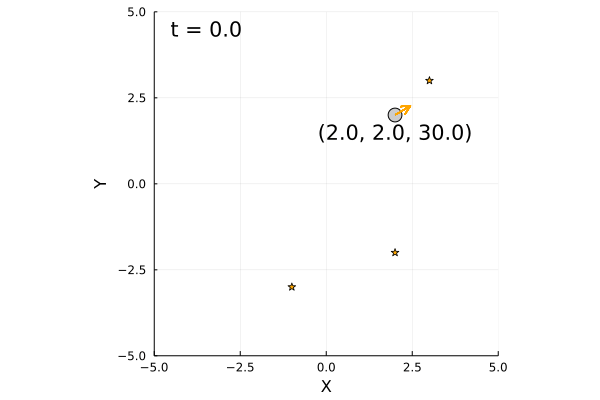

In [116]:
world = MclWorld.World(10, 1)

### 地図を生成して３つランドマークを追加 ###
m = MclWorld.Map()
MclWorld.append(m, MclWorld.Landmark([2, -2]))
MclWorld.append(m, MclWorld.Landmark([-1, -3]))
MclWorld.append(m, MclWorld.Landmark([3, 3]))
MclWorld.append(world, m)

initial_pose = [2, 2, pi/6]
estimator = MclWorld.Mcl(initial_pose, 100, motion_noise_stds=Dict([("nn", 0.01), ("no", 0.02), ("on", 0.03), ("oo", 0.04)]))

circling = MclWorld.EstimationAgent(0.1, 0.2, 10.0/180.0*pi, estimator)
MclWorld.motion_update(estimator, 0.2, 10/180.0*pi, 0.1)

r = MclWorld.RealRobot(initial_pose, :black, 0.2, circling)
MclWorld.append(world, r)

### アニメーション実行 ###
MclWorld.draw(world)

## 移動後のパーティクルの姿勢更新

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_mcl/tmp.gif")
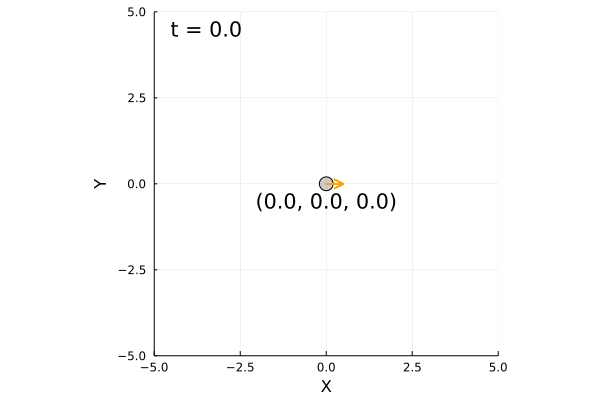

In [117]:
function trial(motion_noise_stds)
    time_interval = 0.1    
    world = MclWorld.World(30, 0.1)

    initial_pose = [0, 0, 0]
    estimator = MclWorld.Mcl(initial_pose, 100, motion_noise_stds=motion_noise_stds)

    circling = MclWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, estimator)
    r = MclWorld.RealRobot(initial_pose, :black, 0.2, circling)
    MclWorld.append(world, r)

    MclWorld.draw(world)
end

motion_noise_stds=Dict([("nn", 0.01), ("no", 0.02), ("on", 0.03), ("oo", 0.04)])
trial(motion_noise_stds)

## パラメータの調整

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_mcl/tmp.gif")
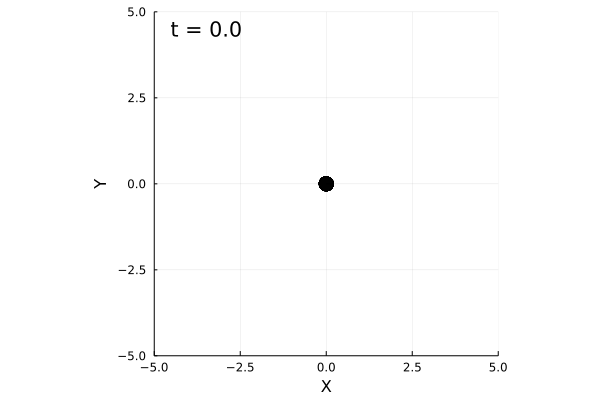

In [118]:
world = MclWorld.World(40, 0.1)
initial_pose = [0, 0, 0]
r = MclWorld.RealRobot(initial_pose, :black, 0.2, MclWorld.IdealAgent(0.1, 0.0))

for i in 1:100
    copy_r = deepcopy(r)
    copy_r.distance_until_noise = rand(copy_r.noise_pdf)
    MclWorld.append(world, copy_r)
end

MclWorld.draw(world)

In [119]:
using DataFrames
poses = DataFrame(r=[sqrt(rb.pose[1]^2 + rb.pose[2]^2) for rb in world.objects], theta=[rb.pose[3] for rb in world.objects])
println(var(poses.theta))
println(mean(poses.r))
sqrt(var(poses.theta)/mean(poses.r))

0.0607667650167277
4.242148413577552


0.11968511163013668

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_mcl/tmp.gif")
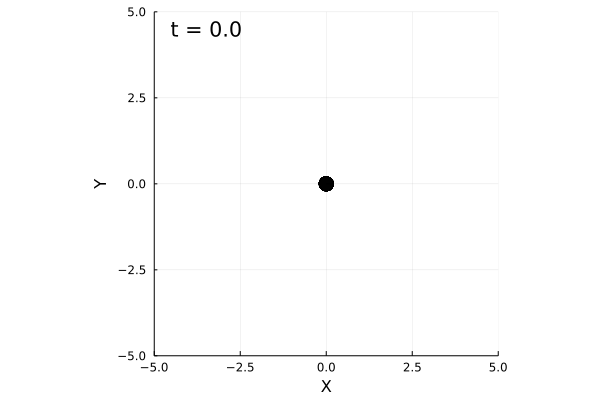

In [120]:
world = MclWorld.World(40, 0.1)
initial_pose = [0, 0, 0]

for i in 1:100
    r = MclWorld.RealRobot(initial_pose, :black, 0.2, MclWorld.IdealAgent(0.1, 0.0))
    MclWorld.append(world, r)
end

MclWorld.draw(world)

In [121]:
poses = DataFrame(r=[sqrt(rb.pose[1]^2 + rb.pose[2]^2) for rb in world.objects], theta=[rb.pose[3] for rb in world.objects])
println(var(poses.r))
println(mean(poses.r))
sqrt(var(poses.r)/mean(poses.r))

0.1537757062579279
4.043208615279726


0.19502073557743727

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_mcl/tmp.gif")
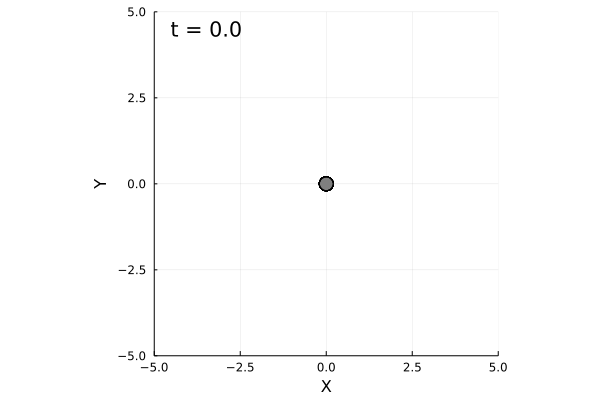

In [122]:
world = MclWorld.World(40.0, 0.1)  
initial_pose = [0, 0, 0]

for i in 1:100
    r = MclWorld.RealRobot(initial_pose, :gray, 0.2, MclWorld.IdealAgent(0.0, 0.1))
    MclWorld.append(world, r)
end

MclWorld.draw(world)

In [123]:
poses = DataFrame(r=[sqrt(rb.pose[1]^2 + rb.pose[2]^2) for rb in world.objects], theta=[rb.pose[3] for rb in world.objects])
println(var(poses.theta))
println(mean(poses.theta))
sqrt(var(poses.theta)/mean(poses.theta))

0.17986866636530993
4.03672021590374


0.21108794527115257

## 求めたパラメータによる動作確認

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_mcl/tmp.gif")
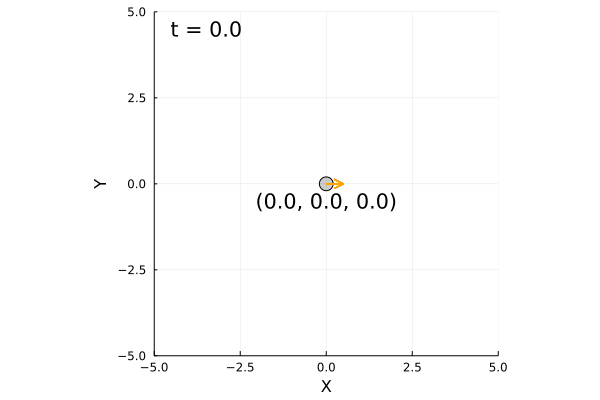

In [124]:
time_interval = 0.1
world = MclWorld.World(30, time_interval) 

initial_pose = [0, 0, 0]
estimator = MclWorld.Mcl(initial_pose, 100)
circling = MclWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, estimator)
r = MclWorld.RealRobot(initial_pose, :black, 0.2, circling)
MclWorld.append(world, r)

MclWorld.draw(world)

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_mcl/tmp.gif")
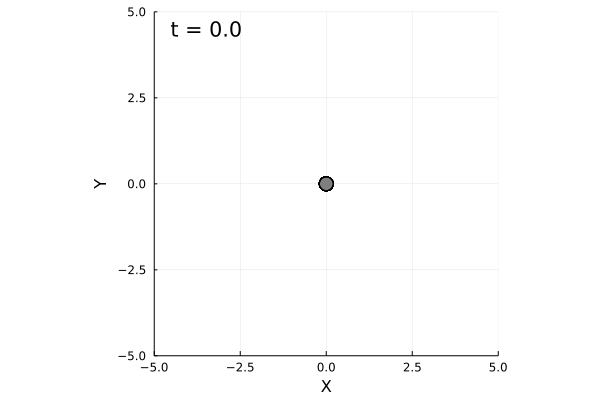

In [125]:
time_interval = 0.1
world = MclWorld.World(30, time_interval) 

for i in 1:100    
    r = MclWorld.RealRobot(initial_pose, :gray, 0.2, MclWorld.IdealAgent(0.2, 10.0/180*pi))
    MclWorld.append(world, r)
end

MclWorld.draw(world)

## 観測後のセンサ値の反映: 尤度関数の決定

In [126]:
m = MclWorld.Map()
MclWorld.append(m, MclWorld.Landmark([1, 0]))
    
distance = []
direction = []

for i in 1:1000
    c = MclWorld.RealCamera(m)
    d = MclWorld.data(c, [0.0, 0.0, 0.0])
    if length(d) > 0
        push!(distance, d[1][1])
        push!(direction, d[1][2])
    end
end

using DataFrames
df = DataFrame(distance=distance, direction=direction)

using Statistics
println(std(df.distance))
println(std(df.direction))

println(mean(df.distance))
println(mean(df.direction))

0.11230949937601245
0.034413927481082074
1.103294178306634
0.03304595810432375


## パーティクルフィルタによる自己位置推定結果

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_mcl/tmp.gif")
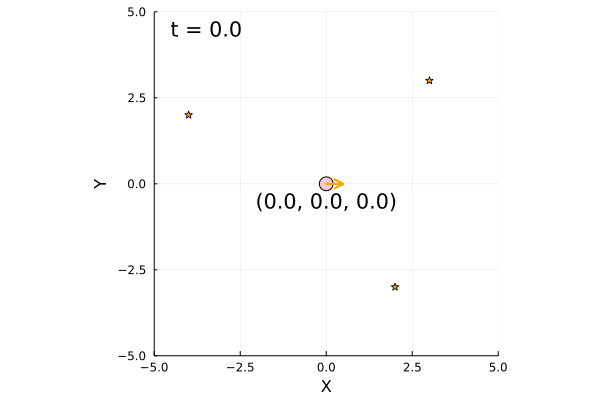

In [129]:
function trial()
    time_interval = 0.1    
    world = MclWorld.World(30, 0.1)

    ### 地図を生成して３つランドマークを追加 ###
    m = MclWorld.Map()
    MclWorld.append(m, MclWorld.Landmark([-4, 2]))
    MclWorld.append(m, MclWorld.Landmark([2, -3]))
    MclWorld.append(m, MclWorld.Landmark([3, 3]))
    MclWorld.append(world, m)
    
    initial_pose = [0, 0, 0]
    estimator = MclWorld.Mcl(initial_pose, 100, map=m)

    circling = MclWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, estimator)
    r = MclWorld.RealRobot(initial_pose, :red, 0.2, circling, sensor=MclWorld.RealCamera(m))
    MclWorld.append(world, r)

    MclWorld.draw(world)
end

trial()